In [24]:
import numpy as np
import pandas as pd
import torch
from model import EEGNet, EEGDataset, create_dataloaders, train_model, plot_metrics, save_training_stats
from explore import apply_bandpass_filter
from load_data import get_dataset
from feature_extraction import extract_all_features_per_trial

In [25]:
train_df = get_dataset("data/SMNI_CMI_TRAIN/Train/")
test_df = get_dataset("data/SMNI_CMI_TEST/Test/")

dataset loaded from tmp/dea5a0ab2c.pickle
dataset loaded from tmp/0d05880708.pickle


In [26]:
df = pd.concat([train_df, test_df], ignore_index=True)

filtered_df = df.groupby(['name', 'trial number', 'sensor position']) \
               .apply(apply_bandpass_filter) \
               .reset_index(drop=True)

/tmp/ipykernel_44171/2937941771.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(apply_bandpass_filter) \


In [27]:
print(filtered_df.shape)
print(filtered_df.head())

(15532032, 10)
   trial number sensor position  sample num  sensor value subject identifier  \
0             0             AF1           0        -2.146                  a   
1             0             AF1           1        -2.146                  a   
2             0             AF1           2        -1.658                  a   
3             0             AF1           3        -0.682                  a   
4             0             AF1           4         2.248                  a   

  matching condition  channel         name      time  filtered_sensor_value  
0             S1 obj        4  co2a0000364  0.000000              -0.004665  
1             S1 obj        4  co2a0000364  0.003906              -0.040292  
2             S1 obj        4  co2a0000364  0.007812              -0.165046  
3             S1 obj        4  co2a0000364  0.011719              -0.429810  
4             S1 obj        4  co2a0000364  0.015625              -0.797100  


In [ ]:
def extract_eeg_sequences(df: pd.DataFrame, group_label: int):
    eeg_segments = []
    labels = []
    ids = []
    grouped = df.groupby(['name', 'trial number'])

    for (name, trial), group in grouped:
        pivot = group.pivot_table(
            index='sensor position',
            columns='time',
            values='filtered_sensor_value'
        )

        eeg_segments.append(pivot.values)
        labels.append(group_label)
        ids.append(group["name"].first())
    return np.stack(eeg_segments), np.array(labels), np.array(ids)

alcohol_df = filtered_df[filtered_df['subject identifier'] == 'a']
control_df = filtered_df[filtered_df['subject identifier'] == 'c']

X_a, y_a = extract_eeg_sequences(alcohol_df, group_label=0)
X_c, y_c = extract_eeg_sequences(control_df, group_label=1)

X_full = np.concatenate([X_a, X_c], axis=0)
y_full = np.concatenate([y_a, y_c], axis=0)

In [46]:
control_df.name.value_counts()

name
co2c0000337    983040
co2c0000339    983040
co2c0000338    966656
co2c0000340    966656
co2c0000342    966656
co2c0000344    966656
co2c0000345    966656
co2c0000341    950272
Name: count, dtype: int64

In [29]:
print(X_full.shape) #924 measurements, 64 sensors, 256 time points

(924, 64, 256)


In [30]:
print(y_full.shape)

(924,)


In [ ]:
df = alcohol_df
eeg_segments = []
labels = []
ids = []
grouped = df.groupby(['name', 'trial number'])

for (name, trial), group in grouped:
    pivot = group.pivot_table(
        index='sensor position',
        columns='time',
        values='filtered_sensor_value'
    )

    eeg_segments.append(pivot.values)
    labels.append(1)
    ids.append(group["name"].iloc[0])
    break

subject_id

'co2a0000364'

In [31]:
train_loader, val_loader = create_dataloaders(X_full, y_full, batch_size=32)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = EEGNet(num_channels=64, num_time_points=256, num_classes=2)
print("Model Summary:")
print(model)

Model Summary:
EEGNet(
  (conv1): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (depthwise_conv): Conv2d(8, 16, kernel_size=(64, 1), stride=(1, 1), groups=8, bias=False)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation1): ELU(alpha=1.0)
  (avgpool1): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
  (dropout1): Dropout(p=0.5, inplace=False)
  (separable_conv): Sequential(
    (0): Conv2d(16, 16, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), bias=False)
    (1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation2): ELU(alpha=1.0)
  (avgpool2): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
  (dropout2): Dropout(p=0.5, inplace=False)
  (classifier): Linear(in_features=128, out

In [35]:
sample_X, _ = next(iter(train_loader))
print(sample_X.shape) 
EEGNet

torch.Size([32, 1, 64, 256])


model.EEGNet

In [36]:
best_model, stats = train_model(
    model,
    train_loader,
    val_loader,
    epochs=100,
    lr=1e-3,
    device="cuda" if torch.cuda.is_available() else "cpu",
    patience=12,      # stop after 12 non-improving epochs
    min_delta=0.001,  # require at least 0.001 drop in val-loss
)
torch.save(model.state_dict(), "models/signal_only_model.pt")

Epoch 001/100 | Train 0.6417 | Val 0.6018 | Acc 0.7027
Epoch 002/100 | Train 0.5809 | Val 0.5319 | Acc 0.7676
Epoch 003/100 | Train 0.5293 | Val 0.4884 | Acc 0.8162
Epoch 004/100 | Train 0.4623 | Val 0.4510 | Acc 0.7946
Epoch 005/100 | Train 0.4018 | Val 0.3729 | Acc 0.8432
Epoch 006/100 | Train 0.3340 | Val 0.3093 | Acc 0.8757
Epoch 007/100 | Train 0.3058 | Val 0.2834 | Acc 0.8919
Epoch 008/100 | Train 0.2835 | Val 0.2534 | Acc 0.9081
Epoch 009/100 | Train 0.2562 | Val 0.2093 | Acc 0.9243
Epoch 010/100 | Train 0.2795 | Val 0.1832 | Acc 0.9622
Epoch 011/100 | Train 0.2449 | Val 0.1911 | Acc 0.9351
Epoch 012/100 | Train 0.2053 | Val 0.1694 | Acc 0.9459
Epoch 013/100 | Train 0.1324 | Val 0.1481 | Acc 0.9459
Epoch 014/100 | Train 0.1606 | Val 0.1414 | Acc 0.9568
Epoch 015/100 | Train 0.1395 | Val 0.1147 | Acc 0.9622
Epoch 016/100 | Train 0.1101 | Val 0.0929 | Acc 0.9622
Epoch 017/100 | Train 0.1847 | Val 0.0690 | Acc 0.9838
Epoch 018/100 | Train 0.1214 | Val 0.0921 | Acc 0.9676
Epoch 019/

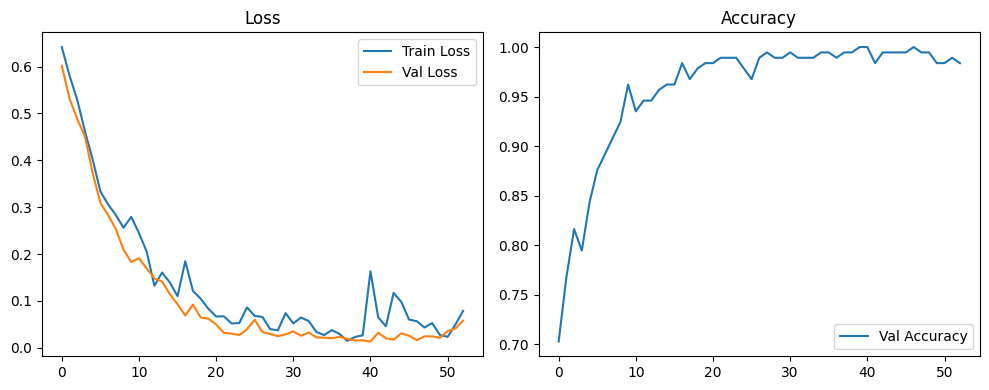

In [37]:
plot_metrics(stats)
save_training_stats(stats, "training_stats.csv")

In [12]:
from torch.utils.data import DataLoader

def evaluate_on_full_data(model, X, y, batch_size=32, device='cpu'):
    model.eval()
    dataset = EEGDataset(X, y)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    correct = 0

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            pred = output.argmax(dim=1)
            correct += pred.eq(y_batch).sum().item()

    return correct / len(dataset)

acc = evaluate_on_full_data(model, X_full, y_full, device=device)
print(f"Accuracy on all data: {acc:.4f}")

Accuracy on all data: 0.9935
